# EDA of Accident Data (2013-2017)
In this notebook we will be looking at the accident data that we previously cleaned in order to explore further into traffic accidents that happened in the UK from 2013 to 2017.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import urllib, os
import glob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_curve, classification_report
import scipy.stats as stats 
import warnings
warnings.filterwarnings("ignore")

# Importing the data

In [14]:
# Import cleaned accident data from csv created at end of accident cleaning notebook
accidents_df = pd.read_csv('data/Accidents/Cleaned_accidents.csv')
accidents_df = accidents_df.drop('Unnamed: 0', axis=1)
accidents_df.head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,...,Urban_or_Rural_Area,LSOA_of_Accident_Location,Hour,Two_Hour_Groupings,Time_of_Day,Was_Daylight,Was_Bad_Weather,Was_Road_Dry,log_Number_of_Casualties,log_Number_of_Vehicles
0,201501BS70001,525130.0,180050.0,-0.198465,51.505538,Slight,1,1,2015-01-12,Monday,...,Urban,E01002825,18,6pm-8pm,Rush hour,No,No,Yes,0.0,0.000000
1,201501BS70002,526530.0,178560.0,-0.178838,51.491836,Slight,1,1,2015-01-12,Monday,...,Urban,E01002820,7,6am-8am,Morning,Yes,No,Yes,0.0,0.000000
2,201501BS70004,524610.0,181080.0,-0.205590,51.514910,Slight,1,1,2015-01-12,Monday,...,Urban,E01002833,18,6pm-8pm,Rush hour,No,Yes,No,0.0,0.000000
3,201501BS70005,524420.0,181080.0,-0.208327,51.514952,Slight,1,1,2015-01-13,Tuesday,...,Urban,E01002874,7,6am-8am,Morning,Yes,No,No,0.0,0.000000
4,201501BS70008,524630.0,179040.0,-0.206022,51.496572,Serious,2,1,2015-01-09,Friday,...,Urban,E01002814,7,6am-8am,Morning,Yes,Yes,No,0.0,0.693147


In [15]:
accidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648205 entries, 0 to 648204
Data columns (total 28 columns):
Accident_Index               648205 non-null object
Location_Easting_OSGR        648205 non-null float64
Location_Northing_OSGR       648205 non-null float64
Longitude                    648205 non-null float64
Latitude                     648205 non-null float64
Accident_Severity            648205 non-null object
Number_of_Vehicles           648205 non-null int64
Number_of_Casualties         648205 non-null int64
Date                         648205 non-null object
Day_of_Week                  648205 non-null object
1st_Road_Class               648205 non-null object
Road_Type                    648205 non-null object
Speed_limit                  648205 non-null int64
Junction_Detail              648205 non-null object
2nd_Road_Class               648205 non-null object
Light_Conditions             648205 non-null object
Weather_Conditions           648205 non-null object
Road

In [16]:
# Seems Date column saved as an object when should be datetime, so need to convert this
# Change Date to datetime
accidents_df['Date'] = pd.to_datetime(accidents_df['Date'], format='%Y/%m/%d')

In [17]:
accidents_df.isna().any().any()

False

# EDA

In [18]:
# Create a serious dataframe to later compare accidents that are serious and fatal to the whole dataset
serious = accidents_df[accidents_df['Accident_Severity']!='Slight']

In [19]:
# set UK flag colors
c_blue = '#00247d'
p_red = '#cf142b'

## What is the overall trend like for accidents in the UK from 2013-2017?
Let's first take a look at accident totals by month and plot it as a time series

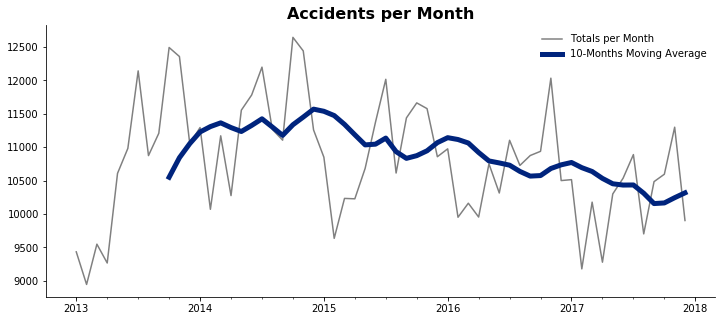

In [20]:
fig, ax = plt.subplots(figsize=(12,5))

accidents_df.set_index('Date').resample('M').size().plot(label='Totals per Month', color='grey', ax=ax)
# Use 10-months moving average which is similar to a popular 200 day moving average
accidents_df.set_index('Date').resample('M').size().rolling(window=10).mean()\
                    .plot(color=c_blue, linewidth=5, label='10-Months Moving Average', ax=ax)
ax.set_title('Accidents per Month', fontweight = 'bold', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(frameon=False, bbox_to_anchor=(1, 1))

sns.despine(ax=ax, top=True, bottom=False, left=False, right=True)

Since 2015, it seems that accidents have been steadily decreasing. We can confirm this with a Dickey Fuller Test, which is a statistical test that tests for stationarity.

In [21]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(accidents_df.set_index('Date').resample('M').size())

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print ('Results of Dickey-Fuller Test:')

print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  0.613133
p-value                         0.987935
#Lags Used                     11.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


Since the p-value is much greater than a typical critical value of 0.05, we can reject the null hypothesis that this time series is stationary meaning that there is a trend!

<br>
Now let's take a look at the accident totals by month for serious and fatal accidents.

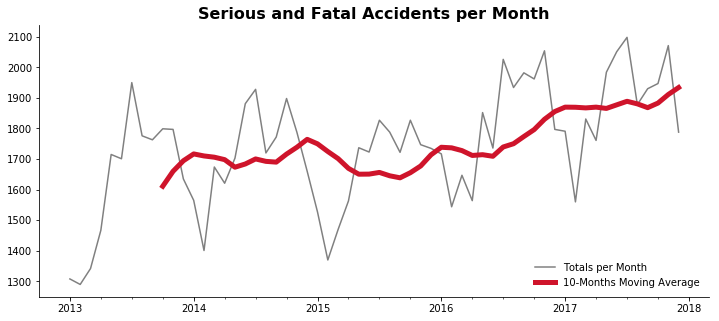

In [24]:
fig, ax = plt.subplots(figsize=(12,5))

serious.set_index('Date').resample('M').size().plot(label='Totals per Month', color='grey', ax=ax)
# Use 10-months moving average which is similar to a popular 200 day moving average
serious.set_index('Date').resample('M').size().rolling(window=10).mean()\
                    .plot(color=p_red, linewidth=5, label='10-Months Moving Average', ax=ax)
ax.set_title('Serious and Fatal Accidents per Month', fontweight = 'bold', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(frameon=False, loc='lower right')

sns.despine(ax=ax, top=True, bottom=False, left=False, right=True)

Unfortunately it seems that serious and fatal accidents have been steadily increasing!

In [11]:
dftest = adfuller(serious.set_index('Date').resample('M').size())

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print ('Results of Dickey-Fuller Test:')

print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  0.215999
p-value                         0.973145
#Lags Used                     11.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


And again we can confirm that this time series is not stationary.
<br>
Let's now look into these time series' further, we saw how there are obvious positive and negative trends, but there also seems to be some seasonality as well. Below we will decompose the time series to get a better sense of these trends.

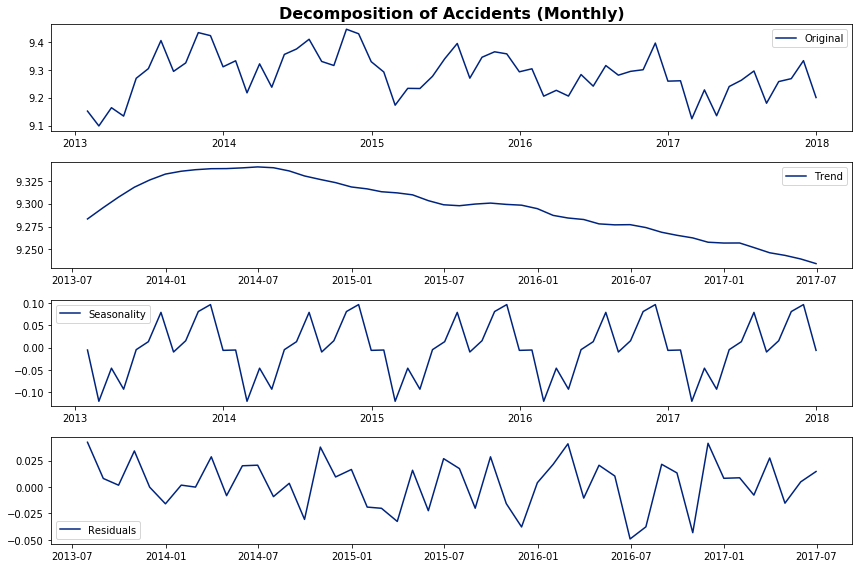

In [15]:
# import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
ts = accidents_df.set_index('Date').resample('M').size()
decomposition = seasonal_decompose(np.log(ts))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(ts), label='Original', color=c_blue)
plt.title('Decomposition of Accidents (Monthly)', fontweight='bold', fontsize=16)
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color=c_blue)
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color=c_blue)
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color=c_blue)
plt.legend(loc='best')
plt.tight_layout()

Here the negative trend is very clear, as well as a seasonal trend.  It is interesting how accidents seem to spike right around the fall time and then decrease during the winter. Let's now decompose the serious and fatal accidents.

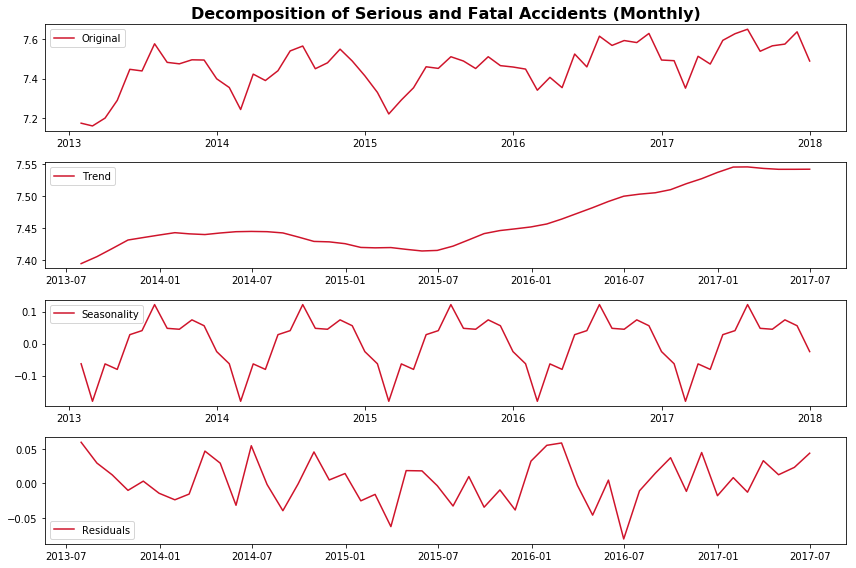

In [13]:
ts = serious.set_index('Date').resample('M').size()
decomposition = seasonal_decompose(np.log(ts))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(ts), label='Original', color=p_red)
plt.title('Decomposition of Serious and Fatal Accidents (Monthly)', fontweight='bold', fontsize=16)
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color=p_red)
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color=p_red)
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color=p_red)
plt.legend(loc='best')
plt.tight_layout()

Here we can see the positive trend happening since around July of 2015.  Also notice how the seasonal trend is a bit different with serious and fatal accidents increasing and spiking during the summer, where before total accidents had two peaks, in summer and during the holidays.

## Is there a certain time of the year where there are more accidents?
Now let's take a look at what months have the most accidents.

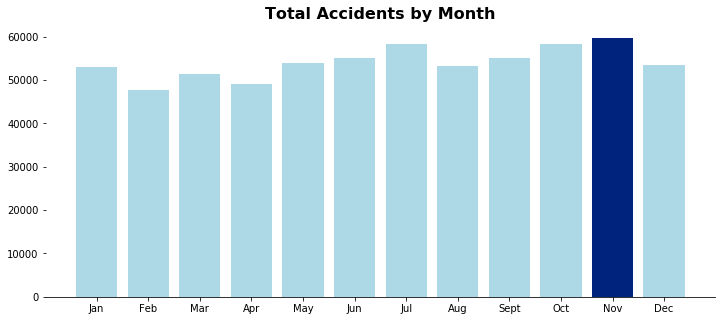

In [14]:
totals_by_month = accidents_df['Date'].dt.month.value_counts().sort_index(ascending=False)

fig, ax = plt.subplots(figsize=(12,5))
colors = ['lightblue',c_blue,'lightblue','lightblue','lightblue','lightblue',
          'lightblue','lightblue','lightblue','lightblue','lightblue','lightblue',]

ax.bar(totals_by_month.index, totals_by_month.values, color=colors)

ax.set_title('Total Accidents by Month', fontweight = 'bold', fontsize=16)
ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])
ax.set_xlabel('')
ax.set_ylabel('')

sns.despine(ax=ax, top=True, bottom=False, left=True, right=True)

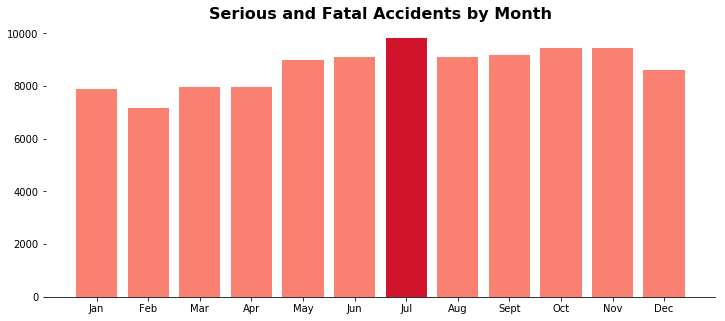

In [15]:
serious_totals_by_month = serious['Date'].dt.month.value_counts().sort_index(ascending=False)

fig, ax = plt.subplots(figsize=(12,5))
colors = ['salmon','salmon','salmon','salmon','salmon',p_red,
          'salmon','salmon','salmon','salmon','salmon','salmon']

ax.bar(serious_totals_by_month.index, serious_totals_by_month.values, color=colors)

ax.set_title('Serious and Fatal Accidents by Month', fontweight = 'bold', fontsize=16)
ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])
ax.set_xlabel('')
ax.set_ylabel('')

sns.despine(ax=ax, top=True, bottom=False, left=True, right=True)

## Day with the most accidents?

In [16]:
# use strftime to get month/day with most accidents
accidents_df.Date.dt.strftime('%m/%d').value_counts().sort_values(ascending=False).head(10)

11/04    2268
11/28    2201
11/25    2171
12/16    2169
01/14    2150
12/09    2148
11/11    2120
11/18    2105
12/08    2092
07/18    2079
Name: Date, dtype: int64

Interesting how the month with the most accidents is November, and the day with the most accidents is November 4th. This might have to do with the national holiday [Guy Fawkes Night](https://en.wikipedia.org/wiki/Guy_Fawkes_Night) which is on November 5th. 

<img src="GuyFawkes.jpeg">

## What day of the week has the most accidents?
Now let's keep going further and look at accidents by day of the week.

In [17]:
# Get daily time series and convert to a df
total_weekday = pd.DataFrame(accidents_df.set_index('Date').resample('1d').size().reset_index())
total_weekday.columns = ['Date', 'Count']
weekdays = total_weekday['Date'].dt.weekday_name

In [18]:
# Group by weekdays and get daily average
weekday_avg = total_weekday.groupby(weekdays)['Count'].mean().reset_index()
weekday_avg.columns = ['Weekday', 'Avg_Accidents']
weekday_avg.set_index('Weekday', inplace=True)
weekday_avg

,Avg_Accidents
Weekday,
Friday,406.042146
Monday,354.265385
Saturday,322.954023
Sunday,272.977011
Thursday,377.858238
Tuesday,376.042146
Wednesday,374.762452


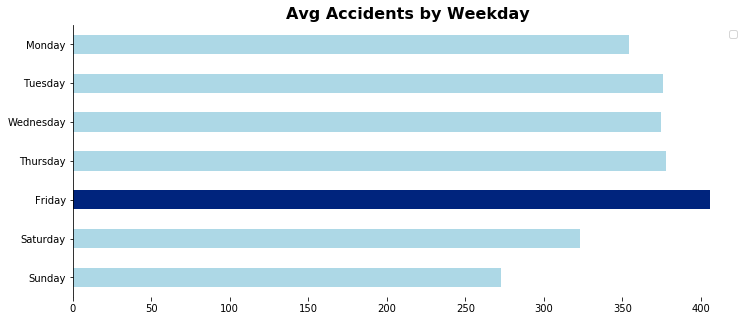

In [19]:
# Need this for labels later (be careful of the order!)
days = ['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']

fig, ax = plt.subplots(figsize=(12,5))
colors = ['lightblue','lightblue',c_blue,'lightblue','lightblue','lightblue','lightblue']

weekday_avg.reindex(days).plot(kind='barh', color=[colors], ax=ax)

ax.set_title('Avg Accidents by Weekday', fontsize=16, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend('')

sns.despine(ax=ax, top=True, bottom=True, left=False, right=True);

In [20]:
# Get daily time series and convert to a df
serious_total_weekday = pd.DataFrame(serious.set_index('Date').resample('1d').size().reset_index())
serious_total_weekday.columns = ['Date', 'Count']
serious_weekdays = total_weekday['Date'].dt.weekday_name

# Group by weekdays and get daily average
serious_weekday_avg = serious_total_weekday.groupby(weekdays)['Count'].mean().reset_index()
serious_weekday_avg.columns = ['Weekday', 'Avg_Accidents']
serious_weekday_avg.set_index('Weekday', inplace=True)
serious_weekday_avg

,Avg_Accidents
Weekday,
Friday,64.429119
Monday,54.269231
Saturday,57.168582
Sunday,52.724138
Thursday,57.712644
Tuesday,57.593870
Wednesday,57.440613


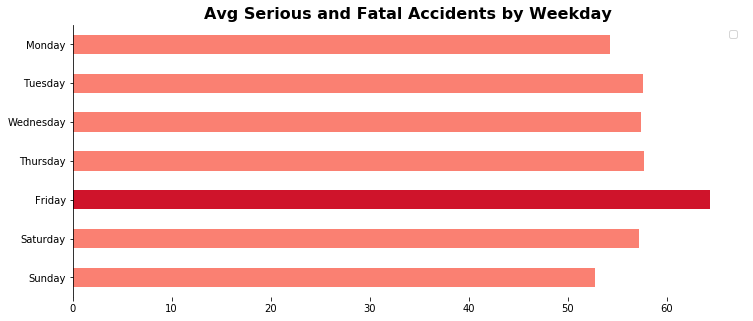

In [21]:
fig, ax = plt.subplots(figsize=(12,5))
colors = ['salmon','salmon',p_red,'salmon','salmon','salmon','salmon']

serious_weekday_avg.reindex(days).plot(kind='barh', color=[colors], ax=ax)

ax.set_title('Avg Serious and Fatal Accidents by Weekday', fontsize=16, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend('')

sns.despine(ax=ax, top=True, bottom=True, left=False, right=True);

Friday was the day of the week with the most accidents on average for both total, and serious/fatal accidents.

## Time of day with the most accidents?
Now let's look at what part of the day has the most accidents.

In [18]:
accidents_df.Two_Hour_Groupings.unique()

array(['6pm-8pm', '6am-8am', '8am-10am', '2pm-4pm', '10pm-12am',
       '12pm-2pm', '10am-12pm', '4pm-6pm', '12am-2am', '8pm-10pm',
       '2am-4am', '4am-6am'], dtype=object)

In [19]:
# Make list to order x labels later
times = ['12am-2am','2am-4am','4am-6am','6am-8am','8am-10am','10am-12pm',
         '12pm-2pm','2pm-4pm','4pm-6pm','6pm-8pm','8pm-10pm','10pm-12am']

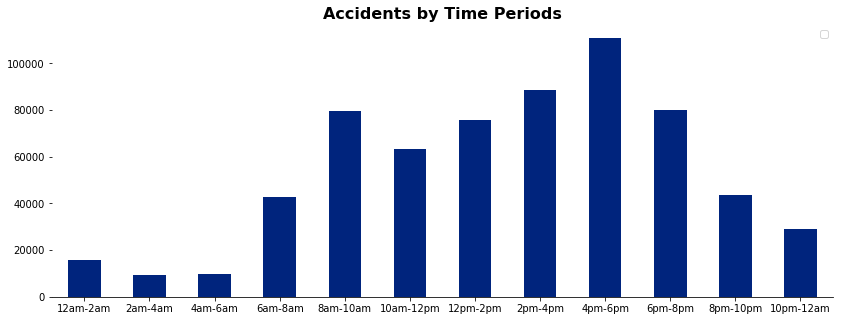

In [20]:
# group accidents by two hour groupings column and reindex by the time groupings listed above
time_groups = pd.DataFrame(accidents_df.groupby('Two_Hour_Groupings').size()).reindex(times)
time_groups.plot(kind='bar', color=c_blue, figsize=(14,5))
plt.title('Accidents by Time Periods', fontsize=16, fontweight='bold')
plt.xlabel('')
plt.xticks(rotation='horizontal')
plt.legend('')
sns.despine(top=True, bottom=False, left=True, right=True);

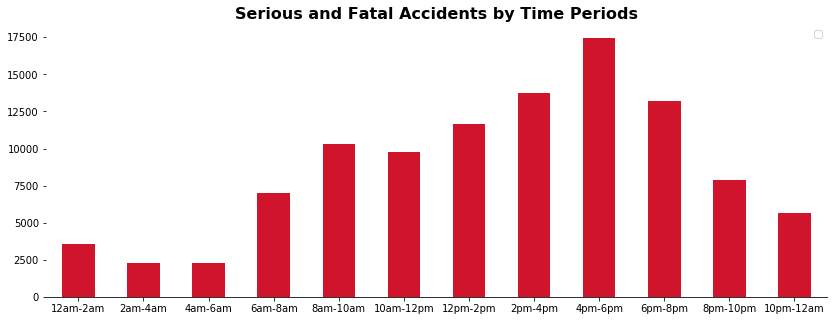

In [22]:
serious_time_groups = pd.DataFrame(serious.groupby('Two_Hour_Groupings').size()).reindex(times)
serious_time_groups.plot(kind='bar', color=p_red, figsize=(14,5))
plt.title('Serious and Fatal Accidents by Time Periods', fontsize=16, fontweight='bold')
plt.xlabel('')
plt.xticks(rotation='horizontal')
plt.legend('')
sns.despine(top=True, bottom=False, left=True, right=True);

Both plots show similar time distributions and that the time period with the most accidents and serious/fatal accidents is from 4pm-6pm. This could be due to rush hour traffic.

## Is there a significant difference in the age of female casualties versus male casualties?

In [28]:
# Import casualties data 
casualties_df = pd.concat([pd.read_csv(f) for f in glob.glob('data/Casualties/Casualties*.csv')], ignore_index = True)
casualties_df.head()

,Accident_Index,Age_Band_of_Casualty,Age_of_Casualty,Bus_or_Coach_Passenger,Car_Passenger,Casualty_Class,Casualty_Home_Area_Type,Casualty_IMD_Decile,Casualty_Reference,Casualty_Severity,Casualty_Type,Pedestrian_Location,Pedestrian_Movement,Pedestrian_Road_Maintenance_Worker,Sex_of_Casualty,Vehicle_Reference
0,2016010000005,5,23.0,0,0,1,1,4.0,1,3,2,0,0,0,1,2
1,2016010000006,7,36.0,0,0,1,1,10.0,1,3,9,0,0,0,2,1
2,2016010000008,5,24.0,0,0,1,1,8.0,1,3,9,0,0,0,1,1
3,2016010000016,9,59.0,3,0,2,1,4.0,1,3,11,0,0,0,2,1
4,2016010000018,6,28.0,0,0,1,1,6.0,1,3,1,0,0,0,1,2


In [29]:
casualties_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916713 entries, 0 to 916712
Data columns (total 16 columns):
Accident_Index                        916713 non-null object
Age_Band_of_Casualty                  916713 non-null int64
Age_of_Casualty                       733043 non-null float64
Bus_or_Coach_Passenger                916713 non-null int64
Car_Passenger                         916713 non-null int64
Casualty_Class                        916713 non-null int64
Casualty_Home_Area_Type               916713 non-null int64
Casualty_IMD_Decile                   538566 non-null float64
Casualty_Reference                    916713 non-null int64
Casualty_Severity                     916713 non-null int64
Casualty_Type                         916713 non-null int64
Pedestrian_Location                   916713 non-null int64
Pedestrian_Movement                   916713 non-null int64
Pedestrian_Road_Maintenance_Worker    916713 non-null int64
Sex_of_Casualty                       916713

In [30]:
casualties_df.Age_of_Casualty.mean()

36.24473461993362

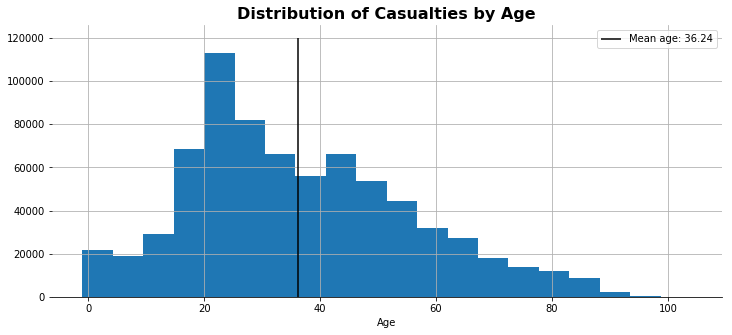

In [29]:
casualties_df.Age_of_Casualty.hist(bins=20, figsize=(12,5))
plt.title('Distribution of Casualties by Age', fontsize=16, fontweight='bold')
plt.vlines(casualties_df.Age_of_Casualty.mean(), ymin=0, ymax=120000, label='Mean age: 36.24')
plt.xlabel('Age')
plt.legend()
sns.despine(top=True, bottom=False, left=True, right=True);

Above you can see the distrubtion of casualties by age. Majority of the accidents seem to be from age 20 - 30 but the average age is around 36. Now we will break up the data by male and female and explore further.

In [31]:
# 1 = Male, 2 = Female, -1 = missing data and will not be used
# More male drivers than female drivers
casualties_df.Sex_of_Casualty.value_counts(normalize=True, dropna=False)

 1    0.591797
 2    0.408035
-1    0.000168
Name: Sex_of_Casualty, dtype: float64

In [32]:
male_casualties = casualties_df[casualties_df['Sex_of_Casualty']==1]['Age_of_Casualty']
female_casualties = casualties_df[casualties_df['Sex_of_Casualty']==2]['Age_of_Casualty']

In [33]:
print('male mean:', male_casualties.mean())
print('female mean:', female_casualties.mean())

male mean: 35.574289365523434
female mean: 37.230572160546544


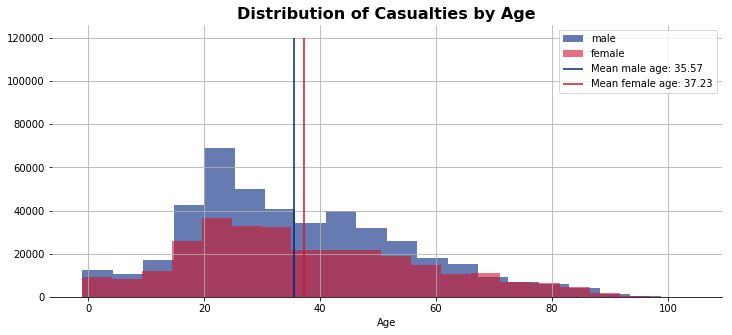

In [33]:
male_casualties.hist(bins=20, color=c_blue, figsize=(12,5), label='male', alpha=0.6)
female_casualties.hist(bins=20, color=p_red, figsize=(12,5), label='female', alpha=0.6)
plt.title('Distribution of Casualties by Age', fontsize=16, fontweight='bold')
plt.vlines(male_casualties.mean(), ymin=0, ymax=120000, color=c_blue, label='Mean male age: 35.57')
plt.vlines(female_casualties.mean(), ymin=0, ymax=120000, color=p_red, label='Mean female age: 37.23')
plt.xlabel('Age')
plt.legend()
sns.despine(top=True, bottom=False, left=True, right=True);

Above you can see the distribution of casualties by age for both male and female. You can see how the average age for males is less than the average age for females. Below we will set up our hypothesis statements to see if there is any statistical significance between this difference.

## Hypothesis
Null Hypothesis: The average age of male casualties in accidents is at least the same as the average age of female casualties in accidents.
<br>

$H_0: \mu_m >= \mu_f$
<br>

Alternative Hypothesis: The average age of male casualties in accidents is less than the average age of female casualties in accidents.
<br>

$H_a: \mu_m < \mu_f$
<br>

Will use an $\alpha$ = 0.05

In [34]:
# Check to see if variance is the same between the samples
print('Variance Male:', np.var(male_casualties))
print('Variance Female:', np.var(female_casualties))

Variance Male: 344.63602140263055
Variance Female: 402.0328765651826


In [35]:
# Since the variance for both samples are not the same, will set equal_var to False in order to run a Welche's t-test
# test will be a two sample t-test (one tail)
t_stat, p_val = stats.ttest_ind(male_casualties, female_casualties, equal_var=False, nan_policy='omit')
print('P-Value:', p_val/2)

P-Value: 9.306860441282675e-281


We get a p-value < 0.05 which means that we can reject our Null Hypothesis and accept the Alternative Hypothesis that there is a statistical significance between the samples.  From our alpha, we can be 95% sure that there is a statistical significance that shows the average age of male casualties is less than the average age of female casualties without this being due to random chance.
<br>

Now we can use Cohen's $d$ in order to measure the effect size or represent the differentiation between our two sample groups.  

In [36]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [37]:
d = Cohen_d(female_casualties, male_casualties)
print('d = {}'.format(d))

d = 0.08633256563223733


An effect of 0.086 is considered a very small effect.  Although it is very small, it still means that there is a an effect happening but it is not so obvious to see without investigating like we have with our hypothesis testing.
<br>

It's interesting how average age of males in accidents is slightly less than the average of females in accidents. Let's now explore this again but just for serious and fatal accidents

## Is there a significant difference in the age of female casualties versus male casualties for serious and fatal accidents?

In [34]:
# Filter male and female dataframes for severity not equal to 3 (slight)
male_serious_casualties = casualties_df[casualties_df['Sex_of_Casualty']==1][['Age_of_Casualty', 'Casualty_Severity']]
male_serious_casualties = male_serious_casualties[male_serious_casualties['Casualty_Severity']!=3]

female_serious_casualties = casualties_df[casualties_df['Sex_of_Casualty']==2][['Age_of_Casualty', 'Casualty_Severity']]
female_serious_casualties = female_serious_casualties[female_serious_casualties['Casualty_Severity']!=3]

male_serious_casualties = male_serious_casualties['Age_of_Casualty']
female_serious_casualties = female_serious_casualties['Age_of_Casualty']

In [35]:
print('male mean:', male_serious_casualties.mean())
print('female mean:', female_serious_casualties.mean())

male mean: 37.82895240254496
female mean: 43.13229584786471


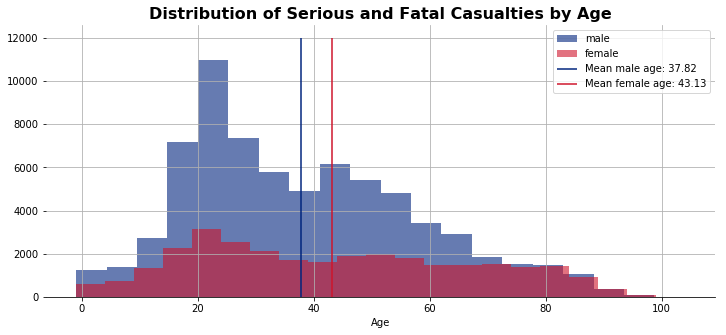

In [40]:
male_serious_casualties.hist(bins=20, color=c_blue, figsize=(12,5), label='male', alpha=0.6)
female_serious_casualties.hist(bins=20, color=p_red, figsize=(12,5), label='female', alpha=0.6)
plt.title('Distribution of Serious and Fatal Casualties by Age', fontsize=16, fontweight='bold')
plt.vlines(male_serious_casualties.mean(), ymin=0, ymax=12000, color=c_blue, label='Mean male age: 37.82')
plt.vlines(female_serious_casualties.mean(), ymin=0, ymax=12000, color=p_red, label='Mean female age: 43.13')
plt.xlabel('Age')
plt.legend()
sns.despine(top=True, bottom=False, left=True, right=True);

## Hypothesis
Null Hypothesis: The average age of male casualties in serious/fatal accidents is at least the same as the average age of female casualties in serious/fatal accidents.
<br>

$H_0: \mu_m >= \mu_f$
<br>

Alternative Hypothesis: The average age of male casualties in serious/fatal accidents is less than the average age of female casualties in serious/fatal accidents.
<br>

$H_a: \mu_m < \mu_f$
<br>

Will use an $\alpha$ = 0.05

In [41]:
# Check to see if variance is the same between the samples
print('Variance Male:', np.var(male_serious_casualties))
print('Variance Female:', np.var(female_serious_casualties))

Variance Male: 386.63026291892015
Variance Female: 556.4916443507184


In [42]:
# Since the variance for both samples are not the same, will set equal_var to False in order to run a Welche's t-test
# test will be a two sample t-test (one tail)
t_stat, p_val = stats.ttest_ind(male_serious_casualties, female_serious_casualties, equal_var=False, nan_policy='omit')
print('P-Value:', p_val/2)

P-Value: 2.2803460923896326e-256


We get a p-value < 0.05 which means that we can reject our Null Hypothesis and accept the Alternative Hypothesis that there is a statistical significance between the samples.  From our alpha, we can be 95% sure that there is a statistical significance that shows the average age of male casualties is less than the average age of female casualties in serious/fatal accidents without this being due to random chance.

In [43]:
d = Cohen_d(female_serious_casualties, male_serious_casualties)
print('d = {}'.format(d))

d = 0.2534486692996894


An effect of 0.253 is considered a small effect, much bigger difference than what we found for all accidents.  Although it is small, it still means that there is a an effect happening but it is not so obvious to see without investigating like we have with our hypothesis testing.

## What age band of drivers has the most accidents?

In [36]:
# Import vehicles data 
vehicles_df = pd.concat([pd.read_csv(f) for f in glob.glob('data/Vehicles/Vehicles*.csv')], ignore_index = True)
vehicles_df.head()

,1st_Point_of_Impact,Accident_Index,Age_Band_of_Driver,Age_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_(CC),Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,...,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_IMD_Decile,Vehicle_Leaving_Carriageway,Vehicle_Location-Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive?
0,1,201301BS70003,8,NaN,10,1,8,2402,0,0,...,1,0,0,NaN,0,0,6,1,8,1
1,1,201301BS70003,7,NaN,-1,1,8,-1,0,0,...,1,0,0,NaN,0,0,18,2,1,1
2,1,201301BS70005,6,NaN,5,1,4,124,0,0,...,2,0,0,NaN,0,0,18,1,3,1
3,0,201301BS70006,8,NaN,-1,1,1,-1,0,0,...,1,0,0,NaN,0,0,14,1,11,1
4,4,201301BS70007,7,NaN,7,1,4,124,0,0,...,1,0,0,NaN,0,0,4,1,3,1


In [37]:
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1270711 entries, 0 to 1270710
Data columns (total 23 columns):
1st_Point_of_Impact                 1270711 non-null int64
Accident_Index                      1270711 non-null object
Age_Band_of_Driver                  1270711 non-null int64
Age_of_Driver                       1017798 non-null float64
Age_of_Vehicle                      1270711 non-null int64
Driver_Home_Area_Type               1270711 non-null int64
Driver_IMD_Decile                   1270711 non-null int64
Engine_Capacity_(CC)                1270711 non-null int64
Hit_Object_in_Carriageway           1270711 non-null int64
Hit_Object_off_Carriageway          1270711 non-null int64
Journey_Purpose_of_Driver           1270711 non-null int64
Junction_Location                   1270711 non-null int64
Propulsion_Code                     1270711 non-null int64
Sex_of_Driver                       1270711 non-null int64
Skidding_and_Overturning            1270711 non-null int64

In [38]:
vehicles_df.Age_Band_of_Driver.value_counts(normalize=True, dropna=False)

 6     0.207363
 7     0.173664
 8     0.156528
-1     0.113333
 5     0.110275
 9     0.087863
 4     0.071877
 10    0.043862
 11    0.026875
 3     0.006245
 2     0.001889
 1     0.000225
Name: Age_Band_of_Driver, dtype: float64

In [39]:
# drop age band of driver where data is missing
vehicles_df = vehicles_df.drop((vehicles_df[vehicles_df['Age_Band_of_Driver']==-1].index))

In [40]:
drivers_df = vehicles_df.groupby('Age_Band_of_Driver').size().reset_index()
drivers_df.columns=['Age_Band_of_Driver', 'Count']

# replace numbers with correct labels from data dictionary
drivers_df.Age_Band_of_Driver = drivers_df.Age_Band_of_Driver.replace([1,2,3,4,5,6,7,8,9,10,11], 
                                                    ['0-5','6-10','11-15','16-20','21-25','26-35',
                                                    '36-45','46-55','56-65','66-75','Over 75'])

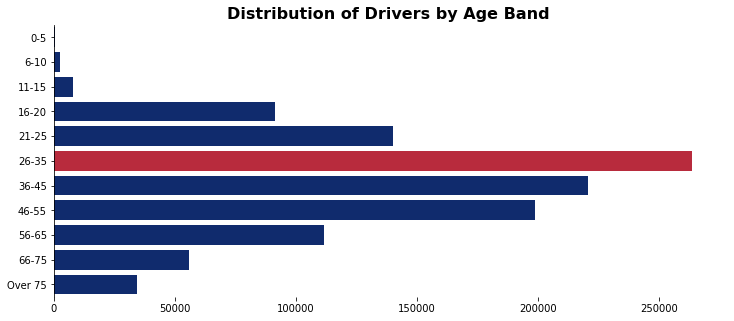

In [42]:
# seaborn barplot
plt.figure(figsize=(12, 5))
sns.barplot(y='Age_Band_of_Driver', x='Count', data=drivers_df, palette=[c_blue,c_blue,c_blue,c_blue,c_blue,
                                                                         p_red,c_blue,c_blue,c_blue,c_blue,c_blue])
plt.title('Distribution of Drivers by Age Band', fontsize=16, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
sns.despine(top=True, right=True, left=False, bottom=True);

Seems like the age band with the most drivers is from 26-35 years old.

## Conclusion
We found many interesting findings by exploring the UK traffic accidents dataset. Here is a short summary of the findings:
- The number of total accidents have been steadily decreasing in the UK since 2015
- However, number serious/fatal accidents have actually been steadily increasing
- The months of the year with peak accidents are November and July
- The day of the week with the most accidents on average is Friday
- Time of the day with the most accidents is from 4PM-6PM
- Majority of casualties are in their early 20s, while average of casualties is around 36
- Female casualties seem to be younger than male casualties with regards to statistical significance
- Age band with the most accidents is 26-35 years old